In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
device = torch.device("cuda:1")

In [3]:

class Block(nn.Module):
    def __init__(self, in_N ,width , out_N ,phi):
        super(Block,self).__init__()
        self.L1 = nn.Linear(in_N,width)
        self.L2 = nn.Linear(width,out_N)
        self.phi = phi
        
        # 가중치 초기화
        self.reset_parameters()
        
    def reset_parameters(self):
        """Xavier 초기화 적용"""
        nn.init.xavier_normal_(self.L1.weight)
        nn.init.xavier_normal_(self.L2.weight)
        nn.init.zeros_(self.L1.bias)
        nn.init.zeros_(self.L2.bias)


    def forward(self,x):
        return self.phi(self.L2(self.phi(self.L1(x))))+ x
    
class Ritz(nn.Module):
    """Parameters:
        in_N  -- input dimension
        out_N -- output dimension
        m     -- width of layers that form blocks
        depth -- number of blocks to be stacked
        phi   -- the activation function
    """
    def __init__(self, input_dim=2, out_dim=1, m =10, depth = 4, phi =nn.Tanh() ):
        super(Ritz, self).__init__()
        self.input_dim = input_dim
        self.out_dim = out_dim
        self.m = m
        self.depth = depth
        self.phi = phi
        
        self.stack = nn.ModuleList()
        self.stack.append( nn.Linear(input_dim, m))
        for i in range(depth):
            self.stack.append(Block(in_N = m , width = m, out_N = m , phi = phi))
        
        self.stack.append(nn.Linear(m, out_dim ))
        
        
        
    def forward(self,x):
        for i in range(len(self.stack)):
            x = self.stack[i](x)
        return x

In [4]:
def derivative(y,t):
    return torch.autograd.grad(y , t , create_graph=True, grad_outputs= torch.ones(y.size()).to(device))[0]

### 방법1
매 에폭 마다 데이터 영역에서 랜덤하게 데이터를 뽑는 방법

In [44]:

def get_interior_points(N=128,d=2):
    """
    randomly sample N points from interior of [-1,1]^d
    """
    return torch.rand(N,d) * 2 - 1

def get_boundary_points(N=33):
    index = torch.rand(N, 1)
    index1 = torch.rand(N,1) * 2 - 1
    xb1 = torch.cat((index, torch.zeros_like(index)), dim=1)
    xb2 = torch.cat((index1, torch.ones_like(index1)), dim=1)
    xb3 = torch.cat((index1, torch.full_like(index1, -1)), dim=1)
    xb4 = torch.cat((torch.ones_like(index1), index1), dim=1)
    xb5 = torch.cat((torch.full_like(index1, -1), index1), dim=1)
    xb = torch.cat((xb1, xb2, xb3, xb4, xb5), dim=0)
    return xb

In [ ]:
network = Ritz( depth= 5 , phi = nn.Tanh() ).to(device)
alpha = torch.ones(1).to(device).requires_grad_(True)
beta = torch.zeros(1).to(device).requires_grad_(True)
optimizer = optim.Adam([{'params' : network.parameters(), 'lr' : 8*1e-4}  , {'params' : alpha , 'lr' : 5*1e-4} , {'params' : beta , 'lr' : 5*1e-4}])
EPOCHS = 50000

In [5]:
def loss_function(x_domain, x_bdry , alpha ,beta):
    u_domain = alpha * network(x_domain) + beta
    u_bdry = alpha * network(x_bdry) + beta
    
    grad_u = derivative(u_domain , x_domain )
    
    loss_r = 0.5 * torch.sum(torch.pow(grad_u, 2),dim=1).reshape(-1,1)- u_domain
    loss_r = torch.mean(loss_r)
    loss_b = torch.mean(torch.pow(u_bdry,2))
    
    return 4 * loss_r + 500 * loss_b


In [62]:
best_loss = float('inf')  # 가장 작은 loss 저장 변수
best_epoch = 0  # 최소 loss 발생한 epoch 저장
best_model_path = "best_model.pth"  # 모델 저장 경로

for epoch in range(0,EPOCHS+1):
    optimizer.zero_grad()
    total_loss = 0
    x_u = get_interior_points()
    x_b = get_boundary_points()
    x_u = x_u.to(device).requires_grad_()
    x_b = x_b.to(device)

    loss = loss_function(x_u,x_b,alpha,beta)
    loss.backward()
    optimizer.step()
    
    # === 현재 에포크가 가장 낮은 Loss라면 모델 저장 ===
    if loss.item() < best_loss:
        best_loss = loss.item()
        best_epoch = epoch
        torch.save(network.state_dict(), best_model_path)  # 모델 가중치 저장
            
    if epoch % 100 == 0:
        print('EPOCH : %6d | Loss : %0.15f' % (epoch, loss))   
        
print('EPOCH : %6d | Loss : %0.15f' %(epoch, loss))   
print('Train Finished')

EPOCH :      0 | Loss : -0.132136985659599
EPOCH :    100 | Loss : -0.196207776665688
EPOCH :    200 | Loss : -0.155676156282425
EPOCH :    300 | Loss : -0.155420750379562
EPOCH :    400 | Loss : -0.201305955648422
EPOCH :    500 | Loss : -0.122511506080627
EPOCH :    600 | Loss : -0.236726224422455
EPOCH :    700 | Loss : -0.173075810074806
EPOCH :    800 | Loss : -0.142688423395157
EPOCH :    900 | Loss : -0.146083787083626
EPOCH :   1000 | Loss : -0.186994388699532
EPOCH :   1100 | Loss : -0.179774865508080
EPOCH :   1200 | Loss : -0.144897863268852
EPOCH :   1300 | Loss : -0.173374369740486
EPOCH :   1400 | Loss : -0.143461063504219
EPOCH :   1500 | Loss : -0.149803131818771
EPOCH :   1600 | Loss : -0.172452852129936
EPOCH :   1700 | Loss : -0.155433073639870
EPOCH :   1800 | Loss : -0.168259397149086
EPOCH :   1900 | Loss : -0.104705564677715
EPOCH :   2000 | Loss : -0.131610825657845
EPOCH :   2100 | Loss : -0.145673841238022
EPOCH :   2200 | Loss : -0.146434068679810
EPOCH :   2

/tmp/ipykernel_390505/669823823.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


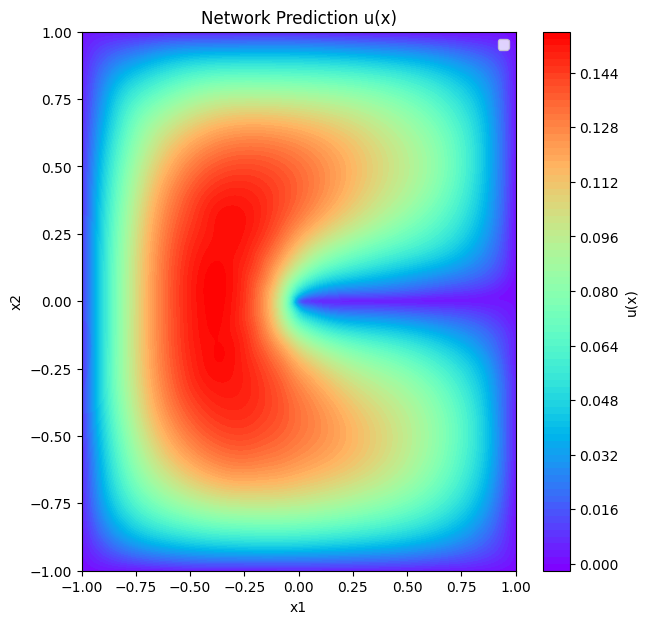

In [69]:

import matplotlib.pyplot as plt

network.load_state_dict(torch.load("best_model.pth"))
network.eval()  # 모델을 평가 모드로 설정
n = 200
x1 = torch.linspace(-1,1 , n)
xx = torch.meshgrid(x1,x1)
x_grid = torch.cat([xx[0].reshape(-1,1) , xx[1].reshape(-1,1)] , dim=1 )
# 전체 mesh의 신경망 예측값 계산
x_grid_np = x_grid.detach().cpu().numpy()
u_pred = alpha.detach().cpu().numpy() * network(x_grid.to(device)).detach().cpu().numpy() + beta.detach().cpu().numpy()


plt.figure(figsize=(7, 7))
plt.tricontourf(x_grid_np[:, 0], x_grid_np[:, 1], u_pred.flatten(), levels=100, cmap="rainbow")  
plt.colorbar(label="u(x)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.title("Network Prediction u(x)")
plt.show()

In [76]:
def u_exact(x):
    r = torch.sqrt(x[:, 0]**2 + x[:, 1]**2)  # r = sqrt(x1^2 + x2^2)
    theta = torch.atan2(x[:, 1], x[:, 0])  # theta = atan2(x2/x1)
    return r**0.5 * torch.sin(theta)  # u(r, theta) = r^(1/2) sin(theta)

u_pred =  alpha.detach().cpu() * network(x_grid.to(device)).detach().cpu()  + beta.detach().cpu()
u_true = u_exact(x_grid).detach().cpu().reshape(-1,1)  # 정확한 해

def relative_l2_norm(u_pred, u_true):
    return torch.norm(u_pred - u_true, p=2) / torch.norm(u_true, p=2)

rel_l2_error = relative_l2_norm(u_pred, u_true)
print(f"Relative L2 Error: {rel_l2_error.item():.6f}")


Relative L2 Error: 1.010702


In [79]:
print('Mean Square Error is : %8.7f' % F.mse_loss(u_pred, u_true).item())

Mean Square Error is : 0.3927911


### 방법2
mini_batch 사용

In [6]:
n = 201
x1 = torch.linspace(-1,1 , n)
xx = torch.meshgrid(x1,x1)
tol = 1e-6
x_grid = torch.cat([xx[0].reshape(-1,1) , xx[1].reshape(-1,1)] , dim=1 )
x_bdry_mesh = x_grid[(x_grid[:,0]==1)|(x_grid[:,0]==-1)|(x_grid[:,1]==1)|(x_grid[:,1]==-1)| \
    ((x_grid[:,0] > 0) & torch.isclose(x_grid[:,1], torch.tensor(0.0), atol=tol)) ]
mask = ~torch.any((x_grid[:, None, :] == x_bdry_mesh).all(dim=2), dim=1)
x_domain_mesh = x_grid[mask].reshape(-1,2)
print(x_domain_mesh.shape)
print(x_bdry_mesh.shape)

torch.Size([39501, 2])
torch.Size([900, 2])


/home/deokhyeonyoon/anaconda3/envs/PINN/lib/python3.12/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [7]:
from torch.utils.data import Dataset, DataLoader

# 도메인 데이터셋 클래스 정의
class DomainDataset(Dataset):
    def __init__(self, x):
        self.x = x

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx]
    
batch_size = 128

# DataLoader 생성 (shuffle=True로 랜덤 샘플링)
domain_loader = DataLoader(DomainDataset(x_domain_mesh), batch_size=batch_size, shuffle=True)
bdry_loader = DataLoader(DomainDataset(x_bdry_mesh), batch_size=batch_size, shuffle=True)

In [8]:
network = Ritz( depth= 5 , phi = nn.Tanh() ).to(device)
x_domain_mesh = x_domain_mesh.to(device).requires_grad_(True)
x_bdry_mesh = x_bdry_mesh.to(device).requires_grad_(True)
alpha = torch.ones(1).to(device).requires_grad_(True)
beta = torch.zeros(1).to(device).requires_grad_(True)
optimizer = optim.Adam([{'params' : network.parameters(), 'lr' : 8*1e-4}  , {'params' : alpha , 'lr' : 5*1e-4} , {'params' : beta , 'lr' : 5*1e-4}])
EPOCHS = 10000

In [9]:
best_loss = float('inf')  # 가장 작은 loss 저장 변수
best_epoch = 0  # 최소 loss 발생한 epoch 저장
best_model_path = "best_model.pth"  # 모델 저장 경로

for epoch in range(0,EPOCHS+1):
    optimizer.zero_grad()
    total_loss = 0
    
    for batch_x_domain, batch_x_bdry in zip(domain_loader, bdry_loader):
        batch_x_domain = batch_x_domain.to(device).requires_grad_(True)
        batch_x_bdry = batch_x_bdry.to(device) #.requires_grad_(True)
        loss = loss_function(batch_x_domain, batch_x_bdry , alpha , beta)
        loss.backward() 
        optimizer.step()
        total_loss += loss.item()
    # === 현재 에포크가 가장 낮은 Loss라면 모델 저장 ===
    if loss.item() < best_loss:
        best_loss = loss.item()
        best_epoch = epoch
        torch.save(network.state_dict(), best_model_path)  # 모델 가중치 저장
            
    if epoch % 1000 == 0:
        print('EPOCH : %6d | Loss : %0.15f' % (epoch, total_loss))   
        
print('EPOCH : %6d | Loss : %0.15f' %(epoch, total_loss))   
print('Train Finished')

EPOCH :      0 | Loss : 391.499137401580811
EPOCH :   1000 | Loss : -0.574815306812525
EPOCH :   2000 | Loss : -1.125433094799519
EPOCH :   3000 | Loss : -1.295774579048157
EPOCH :   4000 | Loss : -1.292361065745354
EPOCH :   5000 | Loss : -1.256110608577728
EPOCH :   6000 | Loss : -1.394825100898743
EPOCH :   7000 | Loss : -1.248763531446457
EPOCH :   8000 | Loss : -1.216344438493252
EPOCH :   9000 | Loss : -1.415056854486465
EPOCH :  10000 | Loss : -1.288511171936989
EPOCH :  10000 | Loss : -1.288511171936989
Train Finished


/tmp/ipykernel_392631/2808192696.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


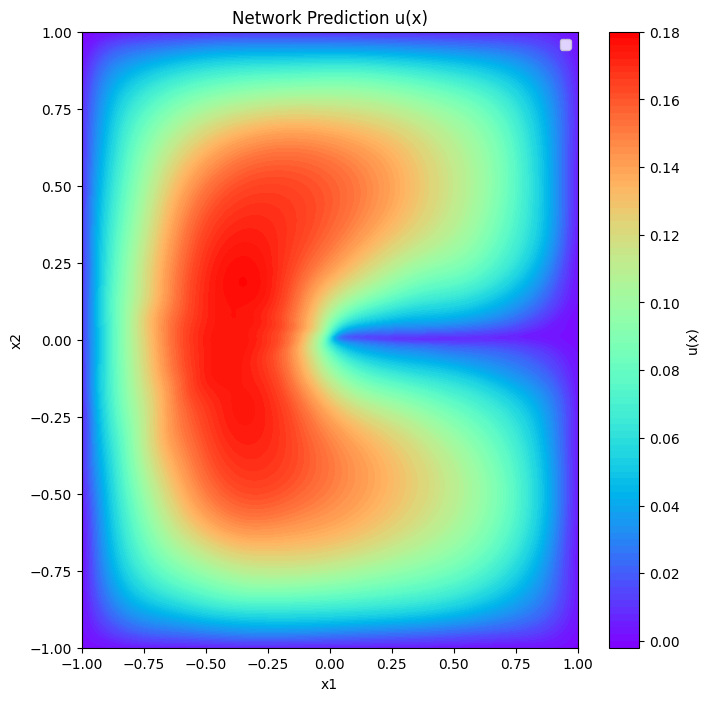

In [10]:
network.load_state_dict(torch.load("best_model.pth"))
network.eval()  # 모델을 평가 모드로 설정

# 전체 mesh의 신경망 예측값 계산
x_grid_np = x_grid.detach().cpu().numpy()
u_pred = alpha.detach().cpu().numpy() * network(x_grid.to(device)).detach().cpu().numpy() + beta.detach().cpu().numpy()

plt.figure(figsize=(8, 8))
plt.tricontourf(x_grid_np[:, 0], x_grid_np[:, 1], u_pred.flatten(), levels=100, cmap="rainbow")  
plt.colorbar(label="u(x)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.title("Network Prediction u(x)")
plt.show()

In [11]:
def u_exact(x):
    r = torch.sqrt(x[:, 0]**2 + x[:, 1]**2)  # r = sqrt(x1^2 + x2^2)
    theta = torch.atan2(x[:, 1], x[:, 0])  # theta = atan2(x2/x1)
    return r**0.5 * torch.sin(theta)  # u(r, theta) = r^(1/2) sin(theta)

u_pred =  alpha.detach().cpu() * network(x_domain_mesh).detach().cpu()  + beta.detach().cpu()
u_true = u_exact(x_domain_mesh).detach().cpu().reshape(-1,1)  # 정확한 해

def relative_l2_norm(u_pred, u_true):
    return torch.norm(u_pred - u_true, p=2) / torch.norm(u_true, p=2)

rel_l2_error = relative_l2_norm(u_pred, u_true)
print(f"Relative L2 Error: {rel_l2_error.item():.6f}")


Relative L2 Error: 1.010231
